# Приоритизация гипотез и оценка результатов А/В-теста.


# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

**Цели и задачи исследования:**
- Приоритизировать гипотезы;
- Запустить A/B-тест;
- Проанализировать результаты.

**Описание данных**

Файл `/datasets/hypothesis.csv.` 
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `/datasets/orders.csv.`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv.` 
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка библиотек.  Предобработка исходных данных.

In [48]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [49]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv') 
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Таблица Hypothesis. 

In [50]:
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Для удобства приведем названия столбцов к змеиному регистру методом `str.lower`. Проверим результат. 

In [51]:
hypothesis.columns = hypothesis.columns.str.lower()
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Таблица Orders.

In [52]:
orders.info()
display(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Переименуем столбцы `transactionId` и `visitorId`  в соответствии с хорошем стилем, а также изменим тип данных в столбце с датой совершения заказа.

In [53]:
#переименовываем столбцы
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

#меняем тип данных
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

#проверяем, сработали ли предыдущие шаги
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


### Таблица Visitors.

In [54]:
visitors.info()
display(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Изменим тип данных в столбце с датой.

In [55]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

## Обработка дубликатов.


Проверим наши таблицы на наличие дубликатов. 

In [56]:
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


Дубликатов не обнаружено, теперь проверим, есть ли пользователи, которые попали в обе группы одновременно. 

In [57]:
duplicate_users = orders.groupby('visitor_id').agg({'group':'nunique'}).query('group > 1').reset_index()
print(len(duplicate_users))
display(duplicate_users.head(5))

58


,visitor_id,group
0,8300375,2
1,199603092,2
2,232979603,2
3,237748145,2
4,276558944,2


58 пользователей попали и в группу A и в группу B. Для корректного теста удалим их из таблицы Orders. Для этого создадим список `duplicates`и скопируем в него их `visitor_id` , далее сделаем срез данных `query()`.

In [58]:
duplicates = duplicate_users['visitor_id'].tolist()

In [59]:
orders = orders.query('visitor_id not in @duplicates')

Таблица `orders` отфильтрована от пользователей, попавших в обе группы. 

## Приоритизация гипотез.

### Расчет ICE.

Посчитаем ICE и добавим его в новый столбец таблицы. Выведем обновленную таблицу и отсортируем ее в порядке убывания приоритета.

In [60]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis.sort_values(by='ICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Наиболее перспективные гипотезы по ICE: `9`, `1`, `8`, `7` и `3`. Остальные гипотезы по уровню ICE сильно остают от лидеров.  

### Расчет RICE.

Проведем похожие на прошлый шаг действия и расчитаем RICE. 

In [61]:
pd.options.display.max_colwidth = 100 # Для того, чтобы гипотезы отобразились целиком

hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis['ICE'] = hypothesis['ICE'].round(2)
display(hypothesis.sort_values(by='RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Пятерка наиболее перспективных гипотез по RICE осталсь прежней, однако изменился их порядок:  `8`, `3`, `1`, `7`, `9`. 

Приоритизация гипотез изменилась из-за учета столбца `reach` с охватом пользователей. Например, у первого места по ICE - гипотезы под номером 9, этот параметр равняется 1, поэтому приоритет данной гипотезы по RICE значительно отстает от гипотезы 8, у которой `reach` равен 10. 

## Анализ A/B теста. 

### График кумулятивной выручки по группам.

Для начала создадим таблицу кумулятивной выручки по дням и группам A/B-тестирования.

In [62]:
# создаем массив уникальных пар значений дат и групп теста
datesgroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о посетителях
visitorsaggregated = datesgroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']
                                                                                   ) 
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersaggregated = datesgroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}
    ), axis=1).sort_values(by=['date','group'])


# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = ordersaggregated.merge(visitorsaggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulative_data.head(10))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845
5 2019-08-03     B      54      53   288850      1803
6 2019-08-04     A      77      71   388030      2562
7 2019-08-04     B      68      66   385740      2573
8 2019-08-05     A      99      92   474413      3318
9 2019-08-05     B      89      87   475648      3280


Теперь можем приступить к построению графиков. 

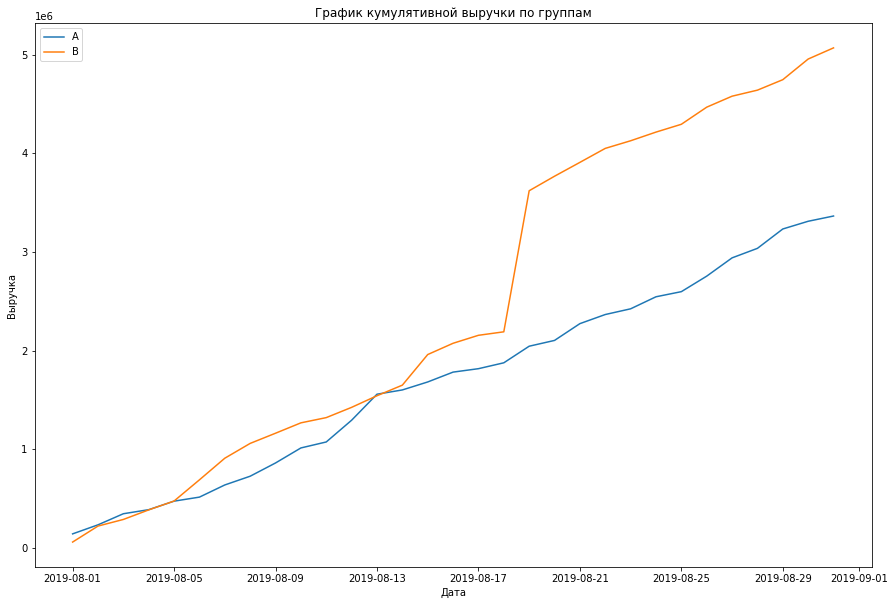

In [63]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,10))
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('График кумулятивной выручки по группам')
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')


plt.legend();

Выручка обеих групп увеличивается в течение всего теста. Это хорошо. Однако если с группой А мы наблюдаем равномерное увеличение выручки, то в случае с группой B видим резкий скачок выручки 18 августа, это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### График кумулятивного среднего чека по группам.

Для этого разделим кумулятивную выручку на кумулятивное число заказов и построим график. 

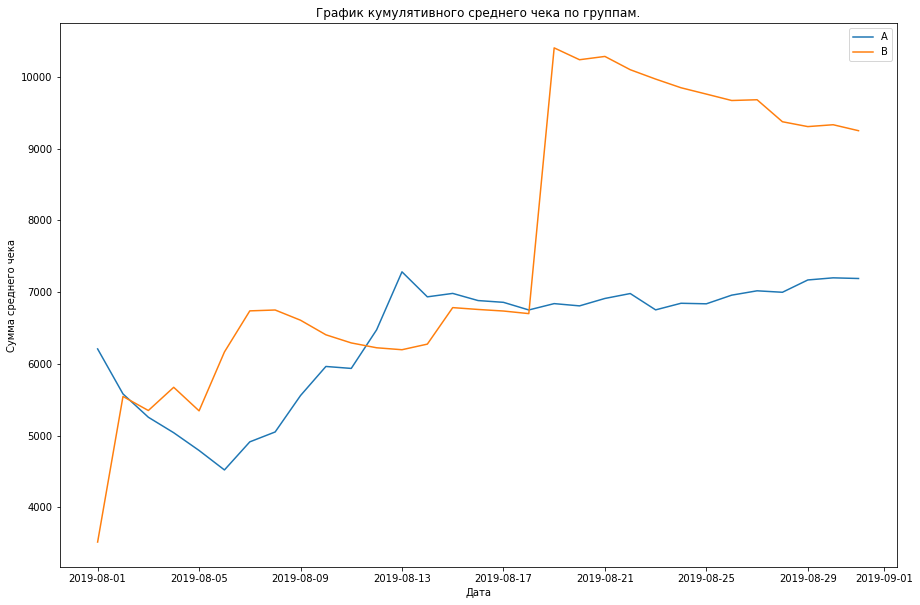

In [64]:
plt.figure(figsize=(15,10))
plt.ylabel('Сумма среднего чека')
plt.xlabel('Дата')
plt.title('График кумулятивного среднего чека по группам.')
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend();

Для группы A видим падение среднего чека в начале, однако затем сумма поднимается до значения примерно в 7000 и стабилизируется. 

С группой B совсем другая картина. Также как и в случае с графиком с выручкой наблюдается резкий всплеск в 18 августа, после чего средний чек начинает плавно падать, скорее всего эту группу попали очень крупные заказы, искажающие общую картину.

### График относительного изменения кумулятивного среднего чека группы B к группе A. 

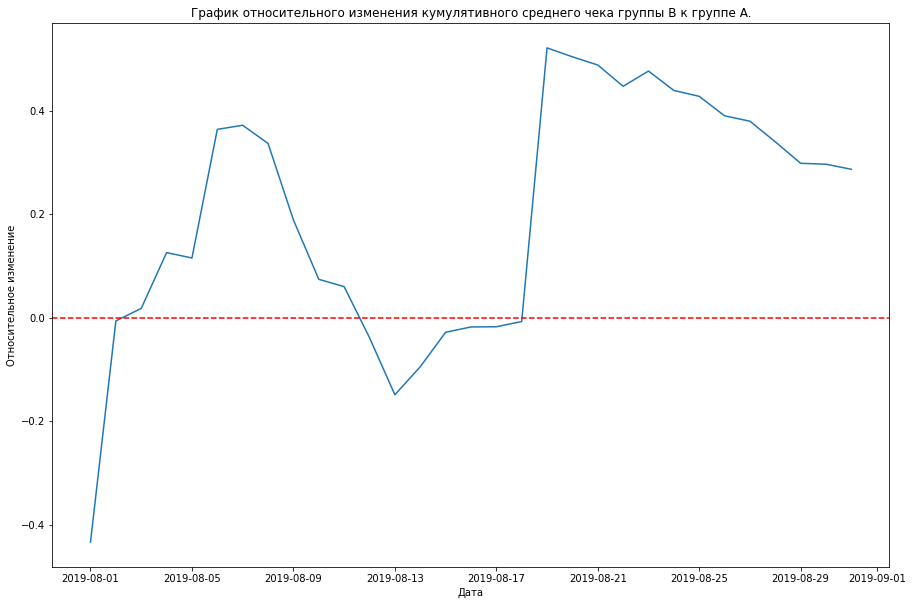

In [65]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.figure(figsize=(15,10))
plt.ylabel('Относительное изменение')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A.')
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--');

График различия между группами резко скачет в нескольких точках. Это опять-таки говорит нам о наличии крупных заказах.

### График кумулятивной конверсии по группам.

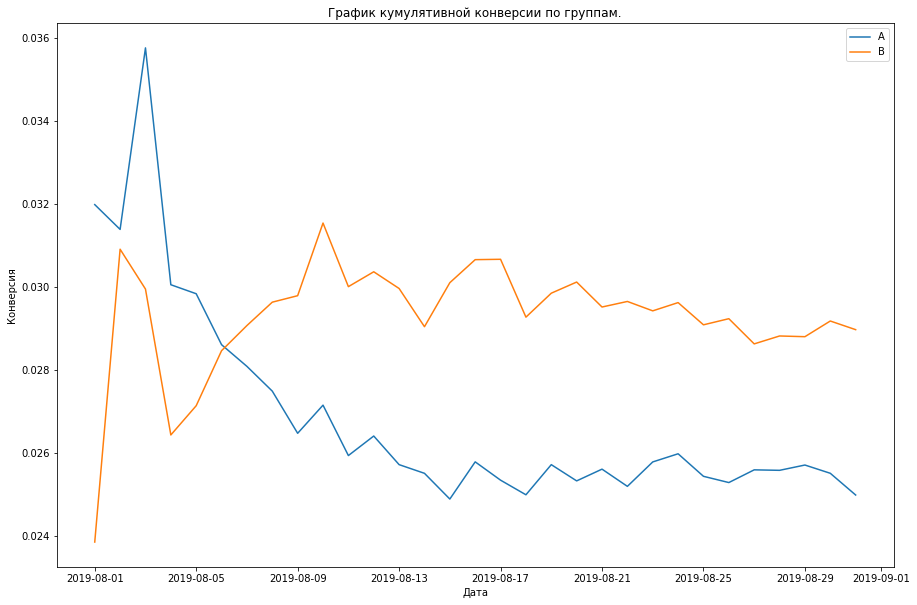

In [66]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(15,10))
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии по группам.')
# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend();

Изначально конверсия группы А была выше группы B, однако начиная с 6 августа группа B вырвалась вперед, а группа A сильно просела. 

### График относительного изменения кумулятивной конверсии группы B к группе A.

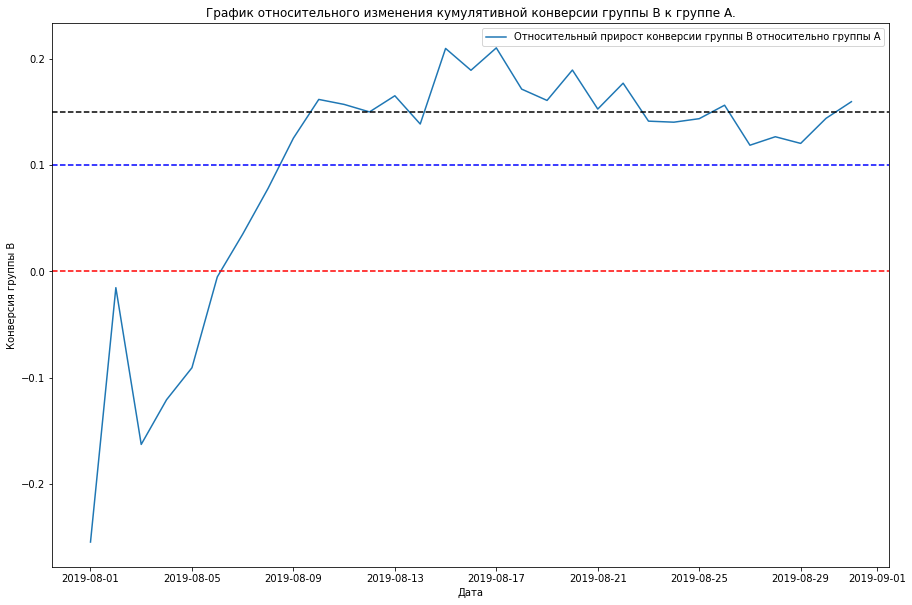

In [67]:
# объединим данные обеих групп
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.figure(figsize=(15,10))
plt.ylabel('Конверсия группы B')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A.')
# строим график
plt.plot(
    merged_cumulative_conversions['date'],
    merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1,
    label="Относительный прирост конверсии группы B относительно группы A"
)
plt.legend()

#добавим пунктирные линии
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.1, color='blue', linestyle='--')
plt.axhline(y=0.15, color='black', linestyle='--');

Почти с самого начала теста конверсия группы B выше группы A. В пике она была выше более чем на `20%`, но в последствии снизилась до примерно `13%`. 

### Точечный график количества заказов по пользователям.

Создадим новый датфрейм с двумя столбцами: `user_id` с идентификатором пользователя, совершившего заказ и  `orders` с количеством заказов. 

In [68]:
#сгруппируем данные по идентификатору пользователя и 
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)

orders_by_users.columns = ['user_id','orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10))

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Теперь перейдем к визуальному анализу. Построим гистограмму распределения числа заказов по пользователям и диаграмму. 

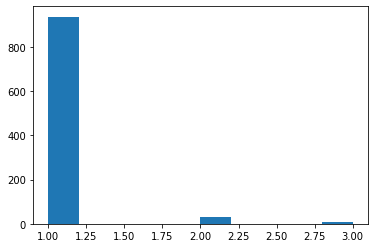

In [69]:
plt.hist(orders_by_users['orders']);

Подавляющее большинство пользователей совершило всего один заказ, однако понять сколько пользователей совершили 2 и более заказов по гистограмме трудно. Построим диаграмму.

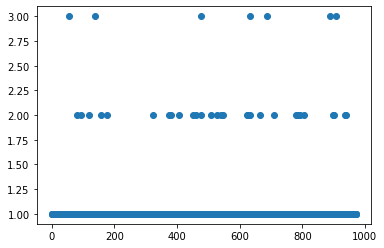

In [70]:
x = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x, orders_by_users['orders']);

Пользователей, совершивших более 2 заказов, очень мало по сравнению с пользователями с количеством заказов равным одному или двум. Такие пользователми вполне могут быть аномалиями. 

### Подсчет 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

Посчитаем 95-й и 99-й перцентили. 

In [71]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не более `5%` пользователей совершали больше двух заказов и не более `1%` - больше четырех заказов.

Определим границу числа заказов на одного пользователя равной `2`. Остальных пользователей будем считать аномальными и отсеим их.

### Точечный график стоимостей заказов.

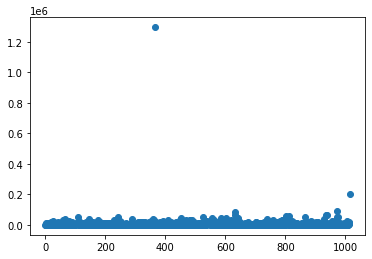

In [72]:
x = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x, orders['revenue']);

Почти все заказы интернет-магазина на сумму менее `100000`. Наблюдаем аномалию: заказ, стоимость которого превышает `1200000`.

Однако по такому графику тяжело определить границу аномальных заказов. Построим тот же график, но ограничим ось Y до `200000`.

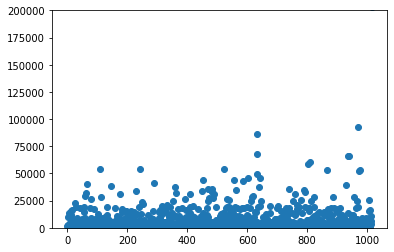

In [73]:
x = pd.Series(range(0, len(orders['revenue'])))

plt.ylim(0, 200000)

plt.scatter(x, orders['revenue']);

Намного нагляднее. По такому графику можно выбрать границу заказов с аномально высокой стоимостью в районе `25000`.
Так как обычно принято отсеивать от 1% до 5% наблюдений с крайними значениями, необходимо найти 95-й и 99-й перцентили стоимости заказов.

### Подсчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [74]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более, чем у 5% заказов чек дороже `28000`. И не больше, чем у 1% заказов - выше 58233. 

Установим границу стоимости заказов равной `28000`. 
Все заказы, имеющие большую стоимость будем считать аномалией и отсеим. 

### Подсчет статистической значимости различий в конверсии между группами по «сырым» данным. 

Создадим новые таблицы: `orders_by_a` и `orders_by_b`, где для пользователей групп A и B, совершивших хотя бы 1 заказ, будет указано число заказов.

In [75]:
orders_by_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_a.columns = ['user_id', 'orders']

orders_by_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_b.columns = ['user_id', 'orders'] 

display(orders_by_a.head(3))
display(orders_by_b.head(3))

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1


,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1


Так же таблицы `visitors_a_daily` с количеством пользователей группы A в указанную дату и `visitors_a_cummulative` c кумулятивным числом пользователей на каждую дату. 

In [76]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)

visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

display(visitors_a_daily.head(5))
display(visitors_a_cummulative.head(5))

,date,visitors_per_date_a
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitors_cummulative_a
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


Такие же таблицы построим для пользователей группы B. 


In [77]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)

visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

display(visitors_b_daily.head(5))
display(visitors_b_cummulative.head(5))

,date,visitors_per_date_b
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


,date,visitors_cummulative_b
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


Теперь таблицы:
- `orders_a_daily`, которая будет содержать в себе количество заказов за каждый день и суммарную выручку группы A
- `orders_a_cummulative`, содержащую кумулятивное число заказов и выручку за каждый день группы A

In [78]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = ['date', 'orders_cummulative_a','revenue_cummulative_a']

display(orders_a_daily.head(5))
display(orders_a_cummulative.head(5))

,date,orders_per_date_a,revenue_per_date_a
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


,date,orders_cummulative_a,revenue_cummulative_a
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


Аналогично для группы B: таблицы `orders_b_daily` и `orders_b_cummulative`

In [79]:
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

display(orders_b_daily.head(5))
display(orders_b_cummulative.head(5))

,date,orders_per_date_b,revenue_per_date_b
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


,date,orders_cummulative_b,revenue_cummulative_b
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


Объединим наши новые таблицы в один датафрейм *data* методом `merge()`

In [80]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Все нужные данные собраны в одну таблицу, содержащую в себе:
- `orders_per_date_a` — количество заказов в выбранную дату в группе A;
- `revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;
- `orders_per_date_b` — количество заказов в выбранную дату в группе B;
- `revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;
- `orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;
- `orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;
- `visitors_per_date_a` — количество пользователей в выбранную дату в группе A;
- `visitors_per_date_b` — количество пользователей в выбранную дату в группе B;
- `visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;
- `visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B

Объявим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. А А тем, кто ничего не заказал, будут соответствовать нули.

In [81]:
sample_a = pd.concat(
    [orders_by_a['orders'],pd.Series(
        0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_a['orders'])),name='orders')],axis=0)

sample_b = pd.concat(
    [orders_by_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_b['orders'])),
                                     name='orders')],axis=0)

Сформулируем гипотезы:
- `Нулевая`: различий в конверсии между группами нет. 
- `Альтернативная`: различия в конверсии между группами есть.

Теперь посчитаем статистическую значимость различия конверсии групп с помощью теста Манна-Уитни.

Округлим p-value и относительное различие в конверсии между группами до 3 знаков после запятой. 

In [82]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))


0.011
0.160


P-value меньше 0.05. Это дает нам основание отвергнуть нулевую гипотезу. 

Анализ сырых данных показывает нам, что в конверсии между группами есть статистически значимые различия. 

Относительный прирост конверсии группы B к конверсии группы A составляет 13.8%.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы:
- `Нулевая гипотеза`: различий в среднем чеке между группами нет. 
- `Альтернативная гипотеза` : различия в среднем чеке между группами есть.

In [83]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


P-value значительно больше 0.05. Значит, оснований отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Стоит отметить, что относительное различие среднего чека целых 25%. Скорее всего это из-за аномальных заказов, разберемся с ними позже. 

### Подсчет статистической значимости различий в конверсии между группами по «очищенным» данным. 

"Очистим" наши данные. Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000. Сделаем срезы пользователей с числом заказов больше 2 — `users_with_many_orders` и пользователей, совершивших заказы дороже 28 000 — `users_with_expensive_orders`. Объединим их в таблице `abnormal_users` и посчитаем, сколько их всего. 

In [84]:
users_with_many_orders = pd.concat(
    [
        orders_by_a[orders_by_a['orders'] > 2]['user_id'],
        orders_by_b[orders_by_b['orders'] > 2]['user_id'],
    ],
    axis=0,
)

users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormal_users.head(5))
print('Аномальных пользователей:',abnormal_users.shape[0]) 

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
dtype: int64

Аномальных пользователей: 55


Теперь приступим к подсчету статистической значимости различий в конверсии между группами теста по очищенным данным.

Создадим выборки количества заказов по пользователям по группам теста: `sample_a_filtered` и `sample_b_filtered`.

In [85]:
sample_a_filtered = pd.concat(
    [
        orders_by_a[
            np.logical_not(orders_by_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

sample_b_filtered = pd.concat(
    [
        orders_by_b[
            np.logical_not(orders_by_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

И применим статистический критерий Манна-Уитни к полученным выборкам.

In [86]:
print('{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

0.009
0.189


Результаты по конверсии практически не изменились. 

P-value также меньше 0.05. Однако относительный прирост конверсии группы B немного подрос и теперь составляет 17% вместо 13% по "сырым" данным.

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

In [87]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.762
-0.022


P-value практически не изменился, но разница между сегментами сократилась с 25% до 2%. Такое большое изменение разницы между группами показывает нам, насколько сильно аномалии влиляли на результаты A/B теста. 

## Вывод

Исходя из анализа A/B теста можем сделать следующие выводы: 
- Есть статистически значимые различия по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий;
- Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами;

Тест можно остановить и считать успешным. Группа B лучше, чем группа A, т.к. при одинаковом среднем чеке имеет большую конверсию из пользователей в покупателей. 